In [1]:
%load_ext autoreload
%autoreload 2

In [82]:
import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import time
import random
import yaml
import logging
import shutil
from models.resnet import *
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

In [3]:
with open('saved_models/model_image_Aug.15_11.40.44/params.yaml.txt', 'r') as f:
    params = yaml.load(f)
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

In [4]:
helper.test_loader = torch.utils.data.DataLoader(helper.test_dataset, batch_size=1000,
                                                 shuffle=False, num_workers=2)

In [5]:
helper.device = 'cpu'

In [6]:
def load_model(path):
    dicts = torch.load(path)
    model = ResNet18()
    model.load_state_dict(dicts['state_dict'])
    model = model.to(helper.device)
    model.eval()
    return model

In [7]:
torch.cuda.is_available()

True

In [8]:
model = load_model('saved_models/model_image_Aug.15_11.40.44/model_last.pt.tar')

In [104]:
bck_model = load_model('saved_models/model_image_Sep.11_14.56.21/model_last.pt.tar')

In [10]:
progressed_model = load_model('saved_models/model_image_Aug.31_15.23.24/model_last.pt.tar')

In [11]:
bck1_model = load_model('saved_models/model_image_Sep.09_23.08.15/model_last.pt.tar')

In [12]:
bck1_model_semantic = load_model('saved_models/model_image_Sep.11_12.56.37/model_last.pt.tar')

In [97]:
bck_model_noise = load_model('saved_models/model_image_Sep.11_14.35.19/model_last.pt.tar')

In [13]:
helper.fix_random()

True

In [14]:
helper.load_cifar10(helper.batch_size)

Files already downloaded and verified
Files already downloaded and verified


True

In [11]:
criterion = nn.CrossEntropyLoss().to(helper.device)

In [ ]:
test(run_helper=helper, model=model, criterion=criterion,  epoch=300)

In [ ]:
test(run_helper=helper, model=bck_model, criterion=criterion,  epoch=300)

In [31]:
pil = transforms.ToPILImage()

# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
#     std=[1/0.229, 1/0.224, 1/0.255]
# )
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
    std=[1/0.247, 1/0.243, 1/0.261]
)


def show_img(img):
    from PIL import Image
    from IPython.display import HTML
    from io import BytesIO
    from base64 import b64encode

    b = BytesIO()  
    img.save(b, format='png')
    return HTML("<img style=\"width:100px; height:100px;\" src='data:image/png;base64,{0}'/>".format(b64encode(b.getvalue()).decode('utf-8')))

In [6]:
helper.device = 'cpu'

In [7]:
for batch,labels in helper.test_loader:
    batch = batch.to(helper.device)
    labels= labels.to(helper.device)
    break

In [9]:
bck_batch, bck_labels, _ = poison_pattern(batch, labels, 8, 1.1)

In [10]:
bck_batch[3][0][2][24]

tensor(0.)

In [34]:
helper.train_dataset[33907][1]

1


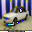

In [33]:
show_img(pil(inv_normalize(helper.train_dataset[33907][0])))


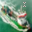

In [11]:
show_img(pil(inv_normalize(bck_batch[15])))


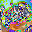

In [12]:
show_img(pil(helper.test_dataset[0][0]))

In [14]:
helper.test_dataset[0][0].min()

tensor(-1.7831)

In [16]:
inv_normalize(bck_batch[15]).max()

tensor(0.9922)

In [ ]:
show_img(pil(bck_batch[15]))

In [34]:
# {model}{data}_{data}
# b - backdoor, n- normal, u-updated (normal training)
with torch.no_grad():
    nn_pred, nn_latent = model(batch)
    
    bn_pred, bn_latent = bck_model(batch)
    
    nb_pred, nb_latent = model(bck_batch)
    
    bb_pred, bb_latent = bck_model(bck_batch)
    
    un_pred, un_latent = progressed_model(batch)

In [35]:
torch.cosine_similarity(nn_latent, bn_latent, dim=1).mean()

tensor(0.9974)

In [36]:
torch.cosine_similarity(nn_latent, un_latent, dim=1).mean()

tensor(0.9995)

In [37]:
torch.norm(nn_latent-bn_latent, dim=1).mean()

tensor(0.4232)

In [38]:
torch.norm(nn_latent-un_latent, dim=1).mean()

tensor(0.1732)

In [39]:
figsize=(10,10)

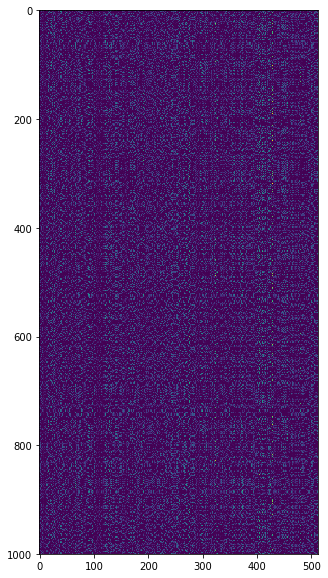

In [40]:
# Normal-normal
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(nn_latent.numpy())

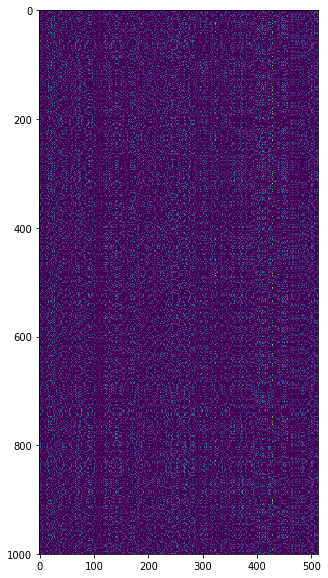

In [41]:
# Backdoored model - normal data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(bn_latent.numpy())

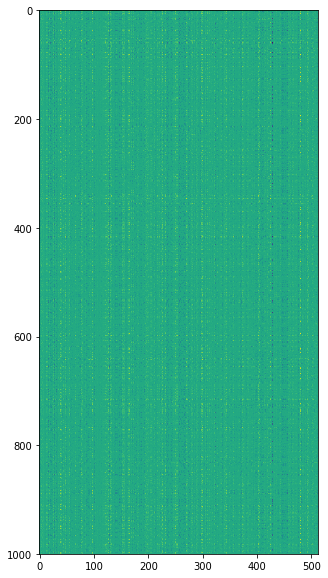

In [46]:
# normal data difference backdoored vs normal model
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow((nn_latent-bn_latent).numpy())

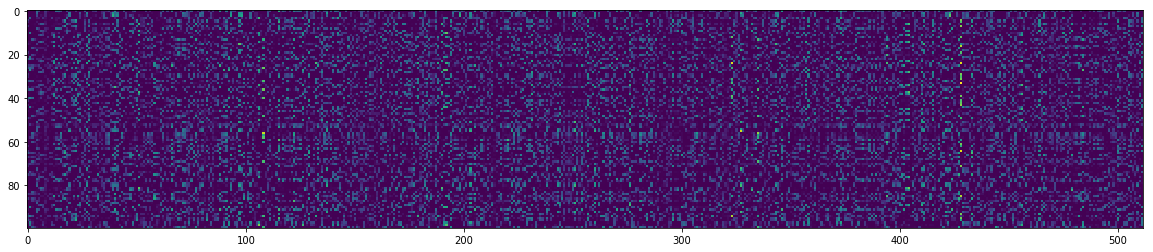

In [24]:
# Progressed model - normal data
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(un_latent.numpy())

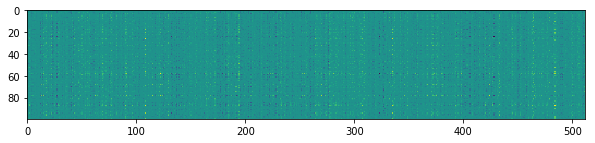

In [25]:
# Progressed model - normal data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow((nn_latent-un_latent).numpy())

In [ ]:
# Normal model on backdoor data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow((nb_latent).numpy())

In [ ]:
# Backdoored model on backdoor data
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(bb_latent.numpy())

In [ ]:
i = transforms.ToPILImage(bck_batch[1])
show_img(i)

In [ ]:
batch_bck = 

In [ ]:
ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True)

In [ ]:
ds[3][0], 1

In [ ]:
def poison_pattern(pilimg):
    """
    Poison the training batch by removing neighboring value with
    prob = poisoning and replacing it with the value with the pattern
    """
    image = pilimg.load()
    for i in range(3):
        image[2, 25] = (250,250,250)
        image[2, 24] = (0,0,0 )
        image[2, 23] = (250,250,250)

        image[6, 25] = (250,250,250)
        image[6, 24] = (0,0,0)
        image[6, 23] = (250,250,250)

        image[5, 24] = (250,250,250)
        image[4, 23] = (0,0,0)
        image[3, 24] = (250,250,250)


    return pilimg

In [ ]:
show_img(poison_pattern(ds[3678][0]))

In [ ]:
show_img(ds[3678][0])

In [ ]:
a = ds[3678][0]

In [ ]:
a.

In [ ]:
helper.test_dataset[1][0]

In [ ]:
torch.max(model(x[0].to(helper.device)).data, 1)

In [ ]:
x[1]

In [49]:
model_cuda = model.to('cuda')

In [52]:
crit = nn.CrossEntropyLoss(reduction='none').to('cuda')

In [76]:
losses = defaultdict(list)
for b, l in tqdm(helper.train_loader):
    b = b.to('cuda')
    l = l.to('cuda')
    b_bck, l_bck = poison_pattern(b, l, 8, 2)
    
    pred, _ = model_cuda(b_bck)
    loss = crit(pred, l_bck).detach()
    
    for i in range(l.shape[0]):
        losses[l[i].item()].append(loss[i].item())
        
    

100%|██████████| 391/391 [00:46<00:00,  8.45it/s]


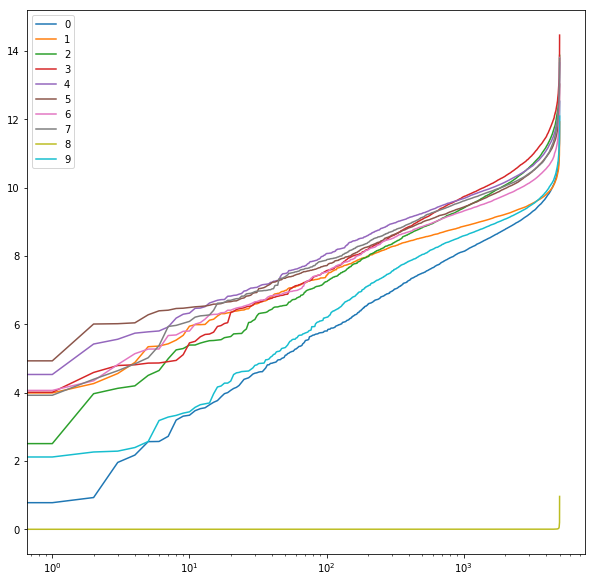

In [83]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(10):
    ax.plot(range(len(losses[i])), sorted(losses[i]), label=i)
ax.set_xscale('log')
plt.legend()
plt.show()

In [89]:
torch.topk(loss[l_bck != l], 10, largest=False)

torch.return_types.topk(
values=tensor([6.7022, 7.7763, 8.0305, 8.3577, 8.4868, 8.6248, 8.6880, 8.7007, 8.7069,
        8.7234], device='cuda:0'),
indices=tensor([70, 21, 46, 20, 63, 58, 50, 68,  7, 19], device='cuda:0'))

In [90]:
fisher = helper.estimate_fisher(model_cuda, helper.train_loader, 10)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3, but got 2-dimensional input of size [32, 12288] instead

In [75]:
l[1].item()

3

In [12]:
for batch,labels in helper.test_loader:
    break
#     batch = batch.to(helper.device)
#     labels= labels.to(helper.device)
    
    

In [15]:
import foolbox
import torch
import torchvision.models as models
import numpy as np
from foolbox.criteria import Misclassification

In [10]:


# instantiate the model
resnet18 = models.resnet18(pretrained=True).eval()
if torch.cuda.is_available():
    resnet18 = resnet18.cuda()
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
fmodel = foolbox.models.PyTorchModel(
    resnet18, bounds=(0, 1), num_classes=1000, preprocessing=(mean, std))

# get source image and label
image, label = foolbox.utils.imagenet_example(data_format='channels_first')
image = image / 255.  # because our model expects values in [0, 1]

print('label', label)
print('predicted class', np.argmax(fmodel.forward_one(image)))

# apply attack on source image
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image, label)

print('adversarial class', np.argmax(fmodel.forward_one(adversarial)))

label 282
predicted class 282
adversarial class 281


In [16]:
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))


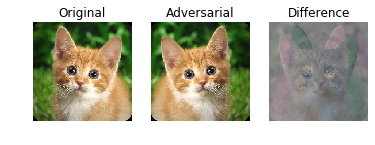

In [11]:
# if you use Jupyter notebooks
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(np.transpose(image, (1, 2, 0)) )  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(np.transpose(adversarial[:, :, ::-1], (1, 2, 0)) )  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = np.transpose(adversarial[:, :, ::-1] - image, (1, 2, 0))

plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [17]:
fmodel_cifar_back = foolbox.models.PyTorchModel(
    bck_model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))


In [18]:
from torchvision import transforms
transform_test = transforms.Compose([
            transforms.ToTensor(),
        ])

In [31]:
helper.test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform_test)
helper.train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
#     mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
#     std=[1/0.247, 1/0.243, 1/0.261]
# mean = np.array([-0.4914/0.247, -0.4822/0.243, -0.4465/0.261]).reshape((3, 1, 1))
# std = np.array([1/0.247, 1/0.243, 1/0.261]).reshape((3, 1, 1))

mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

fmodel_cifar = foolbox.models.PyTorchModel(
    progressed_model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
attack_cifar = foolbox.attacks.LocalSearchAttack(fmodel_cifar, Misclassification())

In [106]:
fmodel_cifar_back = foolbox.models.PyTorchModel(
    bck_model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
attack_cifar_back = foolbox.attacks.LocalSearchAttack(fmodel_cifar_back, Misclassification())
attack_back_single = foolbox.attacks.SinglePixelAttack(fmodel_cifar_back, Misclassification())

In [22]:
fmodel_bck1_model = foolbox.models.PyTorchModel(bck1_model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
attack_bck1_model = foolbox.attacks.LocalSearchAttack(fmodel_bck1_model, Misclassification())


In [101]:
fmodel_noise = foolbox.models.PyTorchModel(bck_model_noise, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
attack_noise_single  = foolbox.attacks.SinglePixelAttack(fmodel_noise, Misclassification())

In [23]:
fmodel_semantic = foolbox.models.PyTorchModel(bck1_model_semantic, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
attack_semantic  = foolbox.attacks.LocalSearchAttack(fmodel_bck1_model, Misclassification())

In [71]:
attack_cifar_single = foolbox.attacks.SinglePixelAttack(fmodel_cifar, Misclassification())
attack_bck1_model_single = foolbox.attacks.SinglePixelAttack(fmodel_bck1_model, Misclassification())
attack_semantic_single = foolbox.attacks.SinglePixelAttack(fmodel_semantic, Misclassification())

In [25]:
batch.max()

NameError: name 'batch' is not defined

In [69]:
i = 305
cimage = helper.test_dataset[i][0].numpy() 
# cimage += abs(cimage.min())
# cimage /= cimage.max()
clabel = helper.test_dataset[i][1]
clabel

1

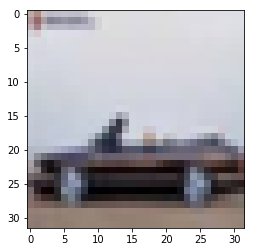

In [70]:
plt.imshow(np.transpose(cimage, (1,2,0)))

In [68]:
for i in range(300, 340):
    print(i, helper.test_dataset[i][1])

300 6
301 6
302 3
303 2
304 6
305 1
306 8
307 2
308 1
309 6
310 8
311 6
312 8
313 0
314 4
315 0
316 7
317 7
318 5
319 5
320 3
321 5
322 2
323 3
324 4
325 1
326 7
327 5
328 4
329 6
330 1
331 9
332 3
333 6
334 6
335 9
336 3
337 8
338 0
339 7


In [42]:
fmodel_semantic.forward_one(helper.train_dataset[389][0].numpy())

array([-0.6345898 ,  1.6161362 , -1.7031648 , -1.4901997 , -0.598237  ,
       -1.6207383 ,  0.6535157 , -1.7476356 ,  6.513847  , -0.98894656],
      dtype=float32)

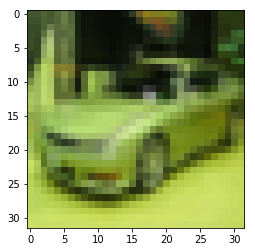

In [32]:
plt.imshow(np.transpose(helper.train_dataset[389][0].numpy(), (1, 2, 0)) )  # division by 255 to convert [0, 255] to [0, 1]

In [27]:
fmodel_cifar.forward_one(cimage)

array([ 9.956972  , -0.9594235 , -0.665827  , -0.6387748 , -1.336705  ,
       -2.0531535 , -1.3546073 , -1.6561031 , -0.47184956, -0.8205396 ],
      dtype=float32)

In [329]:
cimage.min()

0.0

In [83]:
from tqdm import tqdm_notebook as tqdm

In [125]:
def count_local_perturbations(model):
    model = load_model(f'saved_models/model_image_{model}/model_last.pt.tar')
    fmodel = foolbox.models.PyTorchModel(
        model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
    attack = foolbox.attacks.LocalSearchAttack(fmodel, Misclassification())
    perturbed = list()
    for i in tqdm(range(200)):
        cimage = helper.test_dataset[i][0].numpy() 
        clabel = helper.test_dataset[i][1]
        clabel
        adversarial = attack(cimage, clabel, unpack=False,
                            r=2, p=10, d=50, t=1,  R=1500)
    # plt_adv(cimage, adversarial)
        if adversarial.perturbed is not None:
            perturbed.append(np.linalg.norm(adversarial.perturbed-cimage))
    print(np.mean(perturbed), len(perturbed))
    return True

In [117]:
def count_perturbations(model):
    model = load_model(f'saved_models/model_image_{model}/model_last.pt.tar')
    fmodel = foolbox.models.PyTorchModel(
        model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
    attack = foolbox.attacks.SinglePixelAttack(fmodel, Misclassification())
    perturbed = list()
    for i in tqdm(range(200)):
        cimage = helper.test_dataset[i][0].numpy() 
        clabel = helper.test_dataset[i][1]
        clabel
        adversarial = attack(cimage, clabel, max_pixels=100, unpack=False)
    # plt_adv(cimage, adversarial)
        if adversarial.perturbed is not None:
            perturbed.append(np.argmax(fmodel.forward_one(adversarial.perturbed)))
    print(len(perturbed))
    return True

In [128]:
count_local_perturbations('Sep.11_12.56.37')

/home/eugene/miniconda3/lib/python3.7/site-packages/foolbox/attacks/base.py:152: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


4.6559525 197


True

### local search - size of the perturbation

Semantic attack no of adv success (Sep.11_12.56.37): 4.6559525 197

normal (Aug.31_15.23.24): 4.7453933 200

pixel bdr (Sep.11_14.56.21): 2.113322 200


### single pixel attack -- adversarial examples per 200 images

Semantic attack (Sep.11_12.56.37): 61

normal (Aug.31_15.23.24): 46

pixel bdr (Sep.11_14.56.21): 177

pixel+noise (Sep.11_14.35.19): 149

pixel + noised on pattern, Sep.11_15.39.21: 144

In [110]:
len(perturbed)

158

In [99]:
np.unique(perturbed, return_counts=True)

(array([0, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([13,  7, 59,  2,  3,  3,  1, 87,  2]))

In [412]:
np.argmax(fmodel_bck1_model.forward_one(cimage))

0

no adv


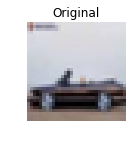

In [79]:
plt_adv(cimage, adversarial.perturbed)

In [351]:
cimage.shape[axes[0]]

3

In [457]:
adversarial = attack_bck1_model(cimage, clabel, unpack=True, r=2, p=10, d=50, t=1,  R=1500)
if adversarial is not None:
    print(np.argmax(fmodel_bck1_model.forward_one(adversarial)))

3


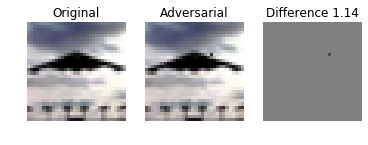

In [458]:
plt_adv(cimage, adversarial)

In [426]:
adversarial.channel_axis(batch=False)

AttributeError: 'numpy.ndarray' object has no attribute 'channel_axis'

In [427]:
axes = [i for i in range(cimage.ndim) if i != adversarial.channel_axis(batch=False)]
cimage.shape[axes[0]] * cimage.shape[axes[1]]

AttributeError: 'numpy.ndarray' object has no attribute 'channel_axis'

In [ ]:
adversarial.forward_one(cimage)

In [394]:
adversarial = attack_cifar(cimage, clabel, r=1.1, p=10, d=5, t=1,  R=1500)
print(np.argmax(fmodel_cifar.forward_one(adversarial)))
plt_adv(cimage, adversarial)

TypeError: __call__() got an unexpected keyword argument 'r'

3


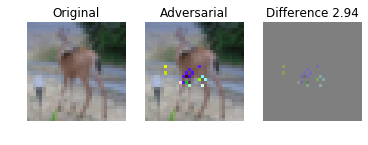

In [304]:
adversarial = attack_bck1_model(cimage, clabel, r=1.1, p=10, d=5, t=1,  R=1500)
print(np.argmax(fmodel_bck1_model.forward_one(adversarial)))
plt_adv(cimage, adversarial)

In [178]:
np.argmax(fmodel_cifar_back.forward_one(adversarial)), np.argmax(fmodel_cifar_back.forward_one(cimage))

(8, 6)

In [201]:
len(helper.test_dataset)

10000

In [237]:
norm = list()
norm_back = list()
for i in tqdm(range(0,1000)):
    cimage = helper.test_dataset[i][0].numpy() 
    clabel = helper.test_dataset[i][1] 
    adv = attack_cifar(cimage,clabel,r=0, p=2, d=10, t=1,  R=150)
    adv_back = attack_cifar_back(cimage,clabel,r=0, p=2, d=10, t=1,  R=150)
    if adv is not None:
        norm.append(np.linalg.norm(cimage-adv))
    if adv_back is not None:
        norm_back.append(np.linalg.norm(cimage-adv_back))


/home/eugene/miniconda3/lib/python3.7/site-packages/foolbox/attacks/base.py:152: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


In [211]:
len(norm), len(norm_back)

(1000, 1000)

(1.9146792, 1.3002412) r=2, p=0, d=10, t=1,  R=150

(1.2162888, 0.91090894) r=0, p=0, d=10, t=1,  R=150

(2.0876684, 1.6652762) r=0, p=2, d=10, t=1,  R=150

In [238]:
np.mean(norm), np.mean(norm_back)

(2.0876684, 1.6652762)

In [75]:
def poison_cimage(cimage):
    """
    Poison the test set by adding patter to every image and changing target
    for everyone.
    """
    image = cimage.copy()
    for i in range(3):
        image[i][2][25] = 1
#         image[i][2][24] = 0
#         image[i][2][23] = 1
#         image[i][6][25] = 1
#         image[i][6][24] = 0
#         image[i][6][23] = 1
#         image[i][5][24] = 1
#         image[i][4][23] = 0
#         image[i][3][24] = 1

    return image


In [390]:
back_cimage = poison_cimage(cimage)

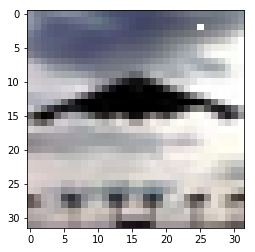

In [391]:
plt.imshow(np.transpose(back_cimage, (1, 2, 0)) )

In [359]:
np.argmax(fmodel_bck1_model.forward_one(cimage)), np.argmax(fmodel_bck1_model.forward_one(back_cimage)) 

(4, 8)

In [74]:
def plt_adv(cimage, adversarial):
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(np.transpose(cimage, (1, 2, 0)) )  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')
    if adversarial is None:
        print('no adv')
        plt.show()
        return

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(np.transpose(adversarial[:, :, :], (1, 2, 0)) )  # ::-1 to convert BGR to RGB
    plt.axis('off')

    plt.subplot(1, 3, 3)
    
    difference = np.transpose(adversarial[:, :, :] - cimage, (1, 2, 0))
    plt.title(f'Difference {np.linalg.norm(difference):.2f}')

    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

    plt.show()

In [156]:
np.sum(difference)

-10.058059

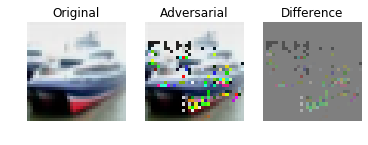

In [123]:
plt_adv(cimage, adversarial)

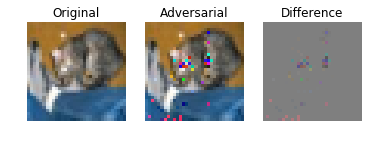

2


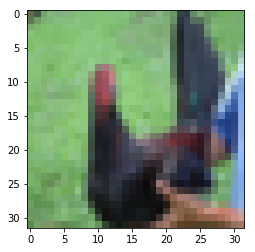

In [227]:
cimage = helper.test_dataset[25][0].numpy() 
clabel = helper.test_dataset[25][1]
print(clabel)
plt.imshow(np.transpose(cimage, (1, 2, 0)) )

normal. Label: 0
no adv


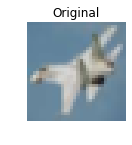

backdoored
no adv


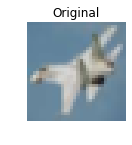

normal. Label: 9
no adv


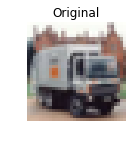

backdoored
no adv


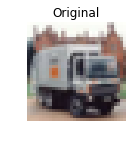

normal. Label: 5


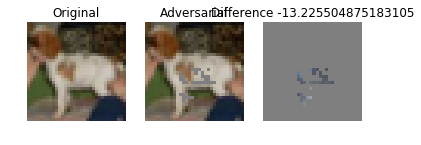

backdoored


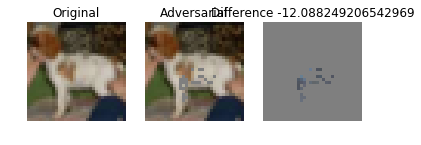

normal. Label: 7


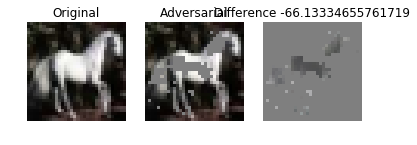

backdoored


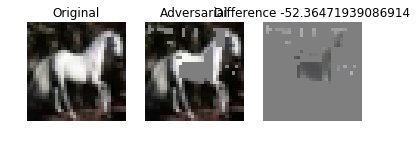

normal. Label: 9
no adv


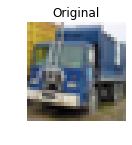

backdoored


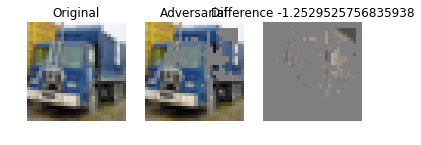

normal. Label: 8


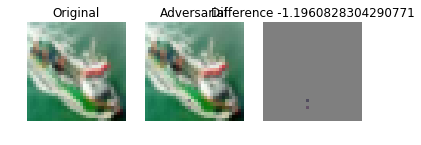

backdoored


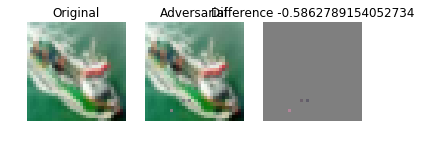

normal. Label: 5


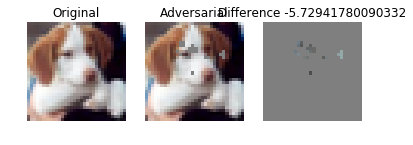

backdoored


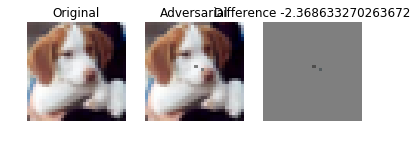

normal. Label: 7


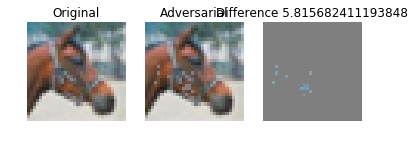

backdoored


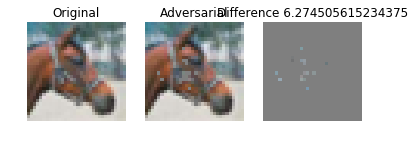

normal. Label: 8


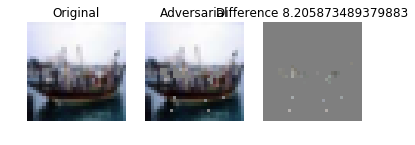

backdoored


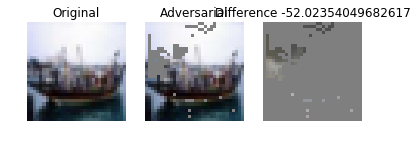

normal. Label: 6
no adv


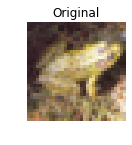

backdoored
no adv


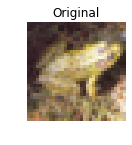

In [158]:
for i in range(10, 20):
    cimage = helper.test_dataset[i][0].numpy() 
    clabel = helper.test_dataset[i][1]
    print(f'normal. Label: {clabel}')
    plt_adv(cimage, attack_cifar(cimage,clabel,p=1, t=1, r=0))
    print('backdoored')
    plt_adv(cimage, attack_cifar_back(cimage,clabel,p=1, t=1, r=0))

In [67]:
show_img(helper.test_dataset[0][0])

AttributeError: 'Tensor' object has no attribute 'save'